# 鋳造製品の欠陥検出

In [2]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

### ファイルパスの読み込み

In [3]:
TRAIN_DIR = './input/train/'
TEST_DIR = './input/test/'

ROWS = 300
COLS = 300
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
random.shuffle(train_images)
train_def =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'def' in i]
train_ok =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'ok' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

print("train_image count:{}".format(len(train_images)))
print("def_image count:{}".format(len(train_def)))
print("ok_image count:{}".format(len(train_ok)))
print("test_image count:{}".format(len(test_images)))

train_image count:250
def_image count:150
ok_image count:100
test_image count:100


### イメージデータの読み込み

In [4]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return img


### 配列データに変換

In [5]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%50 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [6]:
train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 250
Processed 50 of 250
Processed 100 of 250
Processed 150 of 250
Processed 200 of 250
Processed 0 of 100
Processed 50 of 100
Train shape: (250, 300, 300, 3)
Test shape: (100, 300, 300, 3)


### 正解ラベル

Text(0.5, 1.0, 'Defect detection')

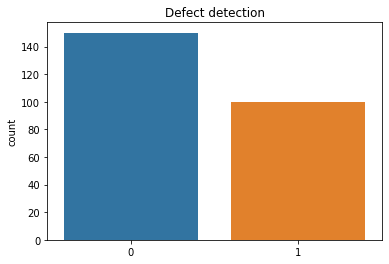

In [7]:
labels = []
for i in train_images:
    if 'ok' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
plt.title('Defect detection')

### イメージ表示

In [8]:
def show_defect(idx):
    defect = read_image(train_def[idx])
    ok = read_image(train_ok[idx])
    pair = np.concatenate((defect, ok), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

### 左が欠陥で右が正常

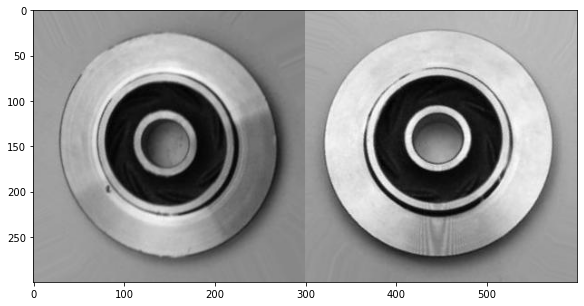

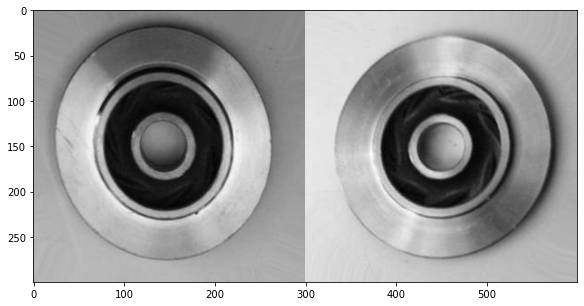

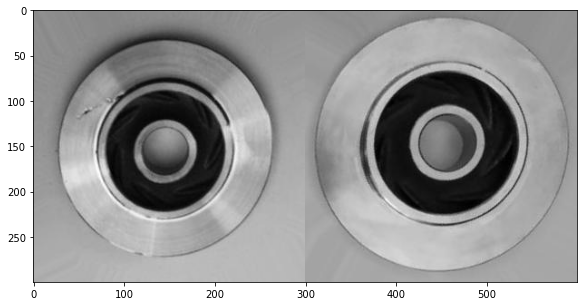

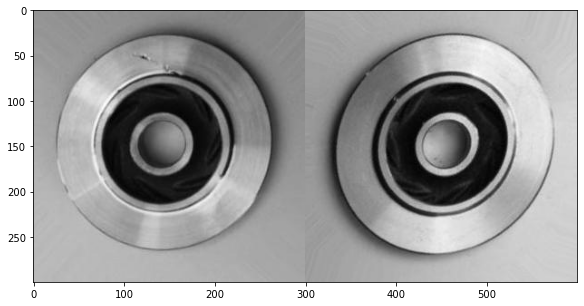

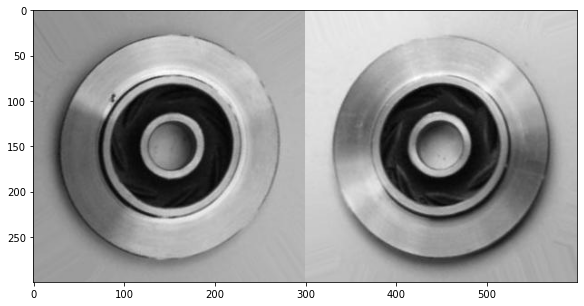

In [9]:
for idx in range(0,5):
    show_defect(idx)

In [10]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


### CNNの構築

In [11]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def defectDetection():
    
    #VGG-16 CNN
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(ROWS, COLS, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = defectDetection()

### 学習＆予測

In [12]:
nb_epoch = 50
batch_size = 1

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_defect():
    
    history = LossHistory()
    # 学習
    model.fit(train, labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    # 予測
    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_defect()

Train on 187 samples, validate on 63 samples
Epoch 1/50
187/187 [==============================] - 6s 30ms/step - loss: 1.3588 - accuracy: 0.5401 - val_loss: 0.6896 - val_accuracy: 0.5873
Epoch 2/50
187/187 [==============================] - 3s 16ms/step - loss: 0.7541 - accuracy: 0.5561 - val_loss: 0.9911 - val_accuracy: 0.5873
Epoch 3/50
187/187 [==============================] - 3s 16ms/step - loss: 0.7751 - accuracy: 0.5294 - val_loss: 0.6811 - val_accuracy: 0.5873
Epoch 4/50
187/187 [==============================] - 3s 16ms/step - loss: 0.7490 - accuracy: 0.6043 - val_loss: 0.8135 - val_accuracy: 0.5873
Epoch 5/50
187/187 [==============================] - 3s 16ms/step - loss: 0.7359 - accuracy: 0.5936 - val_loss: 0.6713 - val_accuracy: 0.5873
Epoch 6/50
187/187 [==============================] - 3s 16ms/step - loss: 0.8125 - accuracy: 0.5989 - val_loss: 0.6728 - val_accuracy: 0.5873
Epoch 7/50
187/187 [==============================] - 3s 16ms/step - loss: 0.7327 - accuracy: 0.6

### 結果の評価

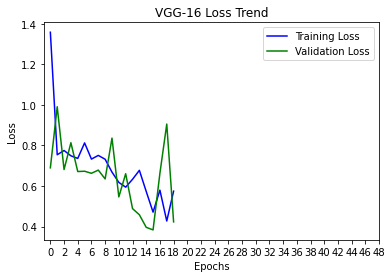

In [13]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [14]:
len(predictions)
predictions[:10]

array([[9.3605453e-03],
       [1.1518407e-15],
       [4.1278868e-04],
       [9.7411968e-02],
       [1.1782129e-09],
       [1.2686851e-02],
       [9.6383357e-01],
       [1.9481709e-19],
       [3.8896018e-04],
       [9.9540126e-01]], dtype=float32)

### 予測したイメージを確認

=== Def ===


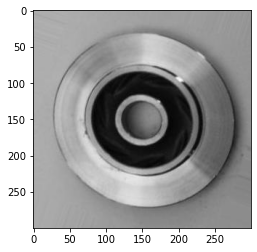

=== Def ===


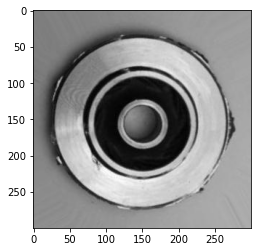

=== Def ===


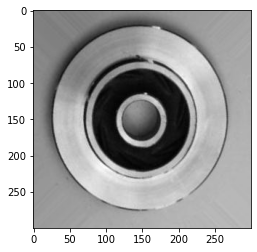

=== Def ===


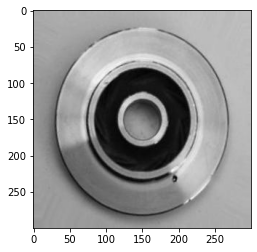

=== Def ===


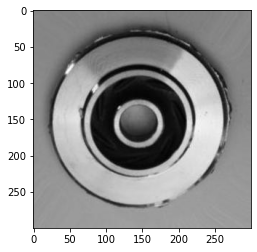

=== Def ===


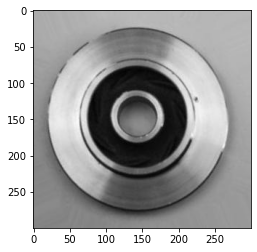

=== OK ===


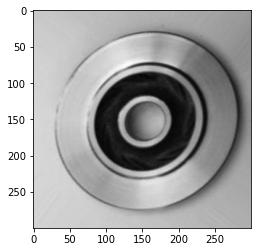

=== Def ===


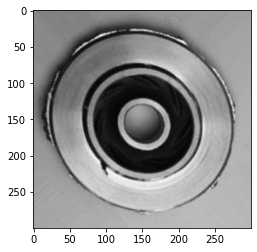

=== Def ===


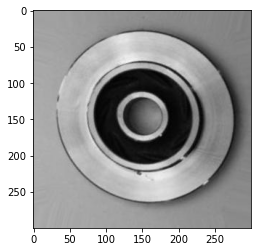

=== OK ===


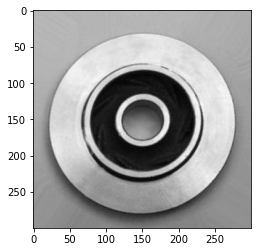

In [15]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('=== OK ==='.format(predictions[i][0]))
    else: 
        print('=== Def ==='.format(1-predictions[i][0]))
        
    plt.imshow(test[i])
    plt.show()

In [16]:
l =np.zeros(len(predictions),dtype=np.int64)
idx = 0
for t in predictions:
    if t >= 0.5:
        l[idx] = 1
    else:
        l[idx] = 0
    idx += 1

In [17]:
l

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

### 出力ファイル

In [18]:
sample = pd.read_csv("./sample_submission.csv",header=None)

In [19]:
for i,t in enumerate(test_images):
    # パスからファイル名を抽出
    basename = os.path.basename(t)
    # 同じファイル名に結果を入れる
    sample.loc[sample[0] == basename,1] = l[i]
    
sample.head()

,0,1
0,19871.jpeg,1
1,29934.jpeg,1
2,39826.jpeg,1
3,49888.jpeg,0
4,59918.jpeg,1


In [20]:
import csv
f = open('out.csv','w',newline='')
writer = csv.writer(f)
writer.writerows(sample.values)
f.close()